This notebook provides code to train a model on the Shipsnet dataset

In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

# Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = 'test_archi_IA'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

Mounted at /content/drive/


Imports

In [ ]:
import numpy as np
import cv2
import requests
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sys
import tensorflow as tf
from time import time
import math
from tensorflow import keras

from tensorflow.keras.layers import Conv2D, DepthwiseConv2D, ReLU, BatchNormalization, add,Softmax, AveragePooling2D, Dense, Input, GlobalAveragePooling2D,Add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.schedules import ExponentialDecay


Extract the dataset

In [ ]:
#extraction de la dataset
import pathlib
import os
import zipfile
from zipfile import ZipFile

# training_dataset_file_name = "./drive/MyDrive/transfer_learning_mobilenet/SHIPSNET_DATASET_240x240.zip"
# with ZipFile(training_dataset_file_name, 'r') as zip:
#      zip.extractall('./drive/MyDrive/transfer_learning_mobilenet/')
data_dir_train = pathlib.Path('./drive/MyDrive/transfer_learning_mobilenet/SHIPSNET_DATASET_240x240') #shipsnet
print(os.path.abspath(data_dir_train))
# data_dir_test = pathlib.Path('./drive/MyDrive/transfer_learning_mobilenet/SHIPSNET_DATASET_240x240/test')
# print(os.path.abspath(data_dir_test))

/content/drive/MyDrive/transfer_learning_mobilenet/SHIPSNET_DATASET_240x240


Build the training and validation dataset

In [ ]:
#import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory


n_classes = 2
image_height = 240
image_width = image_height
n_channel = 3
batch_size = 5

train_dataset = image_dataset_from_directory(
    directory=data_dir_train,
    subset = 'training',
    shuffle = True,
    validation_split = 0.2,
    seed=42,
    batch_size=batch_size,
    image_size=(image_height,image_width))

validation_dataset = image_dataset_from_directory(
    directory=data_dir_train,
    subset = 'validation',
    shuffle = True,
    validation_split = 0.2,
    seed=42,
    batch_size=batch_size,
    image_size=(image_height,image_width))

class_names = validation_dataset.class_names
print(class_names)

Found 3535 files belonging to 2 classes.
Using 2828 files for training.
Found 3535 files belonging to 2 classes.
Using 707 files for validation.
['bateau', 'pas_bateau']


Build the test dataset

In [ ]:
"""test_file_name = "./drive/MyDrive/code_laetitia/test_dataset.zip"
with ZipFile(test_file_name, 'r') as zip:
    zip.extractall('./drive/MyDrive/code_laetitia/')"""

list_test = os.listdir('./drive/MyDrive/transfer_learning_mobilenet/SHIPSNET_DATASET/test')
test_dataset = image_dataset_from_directory(
    directory=data_dir_test,
    seed=42,
    batch_size=batch_size,
    image_size=(image_height,image_width))

class_names_test = list_test
print(class_names_test)

Data augmentation for improved training

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

# train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
# validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
# test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

# preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
def rescale(images):
  return (images * np.asarray(1/127.5, dtype = np.float32)) + np.asarray(-1, dtype = np.float32)


Build your model

In [ ]:
list_arch = []

inputs = tf.keras.Input(shape=(image_height, image_width, n_channel))

network = tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu')(inputs)
network = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(network)


network = tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu')(network)
network = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(network)

network = tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu')(network)
network = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(network)

network = tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu')(network)
network = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(network)

network = tf.keras.layers.Flatten()(network)
network = tf.keras.layers.Dense(32, activation='relu')(network)
outputs = tf.keras.layers.Dense(2, activation='softmax')(network)
model = tf.keras.Model(inputs, outputs)

model.summary()
print(list_arch)
print(len(list_arch))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 240, 240, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 120, 120, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 120, 120, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 60, 60, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 32)        9248  

Checkpoint directory path

In [ ]:
checkpoint_path = "drive/MyDrive/test_archi_IA/checkpoints_shipsnet/weights.03-0.9222.cpkt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

If you have a valid checkpoint for the model you can load it

In [ ]:
model.load_weights(checkpoint_path)

Compile the model

In [ ]:
base_learning_rate = 0.00001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy (from_logits=False),
              metrics=['accuracy'])


Training.  
Checkpoints are saved automatically when validation accuracy increase over the threshold.  
Shipsnet has 3 time more no_boat images so configure the class weight

In [ ]:
class_weight = {
    0 : 1,
    1 : 3
}
initial_epochs = 1
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="drive/MyDrive/test_archi_IA/checkpoints_shipsnet/weights.{epoch:02d}-{val_accuracy:.4f}.cpkt",
                                                 save_weights_only=True,
                                                 monitor='val_accuracy',
                                                 save_best_only=True,
                                                 mode='max',
                                                 initial_value_threshold = 0.90,
                                                 verbose=1)
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset,
                    # class_weight = class_weight,
                    callbacks=cp_callback
                    )

NameError: ignored

Evaluate model on test dataset

In [ ]:
scores = model.evaluate(test_dataset, verbose=1)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100)) 

NameError: ignored

Visualize the model predictions on a batch of images from the dataset

[255. 247. 224.]


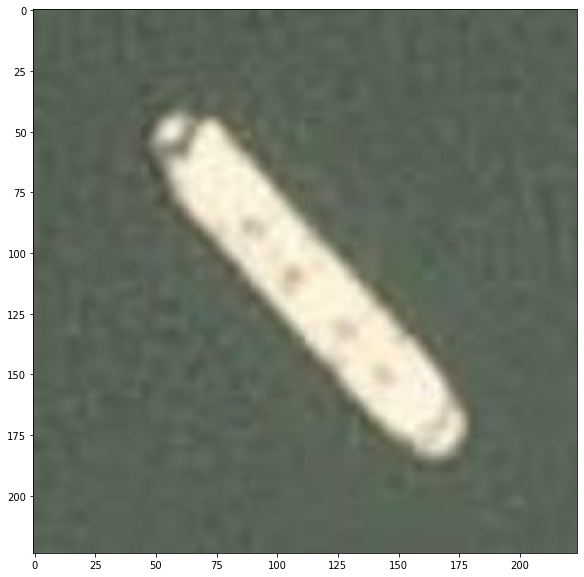

In [ ]:
# Show image --> Image are modified

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  image = images[0].numpy()
  # for i in range(4):
  #   ax = plt.subplot(2, 2, i + 1)
  #   plt.imshow(images[i].numpy().astype("uint8"))
  #   plt.title(class_names[labels[i]])
  #   plt.axis("off")

plt.imshow(image.astype("uint8"))
print(image[75][72])